In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
relations = ['Cause-Effect', 'Component-Whole', 'Entity-Destination', 'Product-Producer', 'Entity-Origin',
             'Member-Collection', 'Message-Topic', 'Content-Container', 'Instrument-Agency', 'Other']

dataset_dir = os.path.join("..", "dataset", "")
train_path = os.path.join(dataset_dir, "train.txt")
max_words = 10000

texts = list()
labels = list()
with open(train_path) as fp:
    while True:
        line = fp.readline()
        label = fp.readline()
        if not line or not label:
            break
        texts.append(line.split(" ", 1)[1])
        labels.append(label.split('(')[0])


tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sentences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index

maxlen = max(map(len, sentences))

X = tf.keras.preprocessing.sequence.pad_sequences(sentences, maxlen=maxlen)
Y = list(map(relations.index, labels))
Y = np.eye(len(relations))[Y]

In [4]:
train_ratio = 0.75
num_sample = Y.shape[0]
num_train = int(num_sample * train_ratio)
rand_indices = np.random.permutation(np.arange(num_sample))
indices_train = rand_indices[:num_train]
indices_val = rand_indices[num_train:]

X_train = X[indices_train]
X_val = X[indices_val]
Y_train = Y[indices_train]
Y_val = Y[indices_val]

In [9]:
glove_dir = os.path.join("..", "res", "")
embedding_dim = 300

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.%dd.txt' % embedding_dim), encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [8]:
model = tf.keras.models.Sequential()
model.add(layers.Embedding(max_words, embedding_dim, mask_zero=True))

model.add(layers.Bidirectional(layers.LSTM(128, go_backwards=True,recurrent_dropout=0.2, dropout=0.2)))

model.add(layers.Dense(len(relations), activation='softmax'))

model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])
model.fit(X_train, Y_train, epochs=10, batch_size=32, validation_data=(X_val, Y_val))

InternalError: CUDA runtime implicit initialization on GPU:0 failed. Status: out of memory

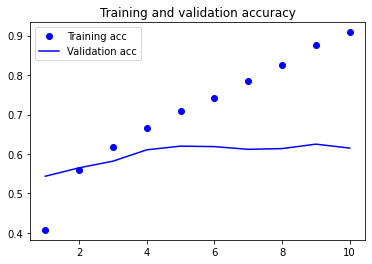

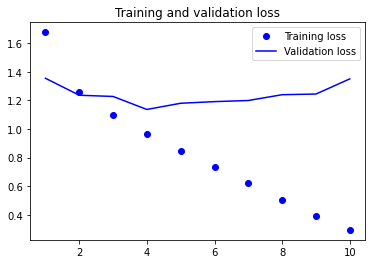

In [19]:
accuracy = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [20]:
test_path = os.path.join(dataset_dir, "test.txt")

test_texts = list()
with open(test_path) as fp:
    while True:
        line = fp.readline()
        if not line:
            break
        test_texts.append(line.split(" ", 1)[1])

test_sentences = tokenizer.texts_to_sequences(test_texts)
test_maxlen = max(map(len, test_sentences))
X_test = tf.keras.preprocessing.sequence.pad_sequences(test_sentences, maxlen=maxlen)

preds = model.predict(X_test)
preds = np.argmax(preds,axis=1)
preds = list(map(lambda x:relations[x],preds))
pred_path = os.path.join('..','output', "prediction.txt")
with open(pred_path,'w+') as fp:
    fp.write("\n".join(preds))

In [6]:
tmp1 = model.predict(X_val)
tmp1 = np.argmax(tmp1,axis=1)
# tmp = np.asarray(map(lambda x:relations[x],tmp))
tmp2 = Y_val.argmax(axis=1)
(tmp1 == tmp2).sum()/tmp1.shape[0]

0.61375